In [93]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA


%matplotlib inline

In [84]:
pd.set_option('display.max_columns', 500)
import matplotlib 

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18
plt.rcParams['figure.figsize'] = 12, 6

In [85]:

df = pd.read_csv('data/zillow_data.csv')

In [86]:
df.head(5)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,345700.0,346700.0,347800.0,349000.0,350400.0,352000.0,353900.0,356200.0,358800.0,361800.0,365700.0,370200.0,374700.0,378900.0,383500.0,388300.0,393300.0,398500.0,403800.0,409100.0,414600.0,420100.0,426200.0,432600.0,438600.0,444200.0,450000.0,455900.0,462100.0,468500.0,475300.0,482500.0,490200.0,498200.0,507200.0,516800.0,526300.0,535300.0,544500.0,553500.0,562400.0,571200.0,579800.0,588100.0,596300.0,604200.0,612200.0,620200.0,627700.0,634500.0,641000.0,647000.0,652700.0,658100.0,663300.0,668400.0,673400.0,678300.0,683200.0,688300.0,693300.0,698000.0,702400.0,706400.0,710200.0,714000.0,717800.0,721700.0,725700.0,729900.0,733400.0,735600.0,737200.0,739000.0,740900.0,742700.0,744400.0,746000.0,747200.0,748000.0,749000.0,750200.0,752300.0,755300.0,759200.0,764000.0,769600.0,775600.0,781900.0,787900.0,793200.0,798200.0,803100.0,807900.0,812900.0,818100.0,823100.0,828300.0,834100.0,839800.0,845600.0,851800.0,858000.0,864400.0,870700.0,876200.0,880700.0,884400.0,887600.0,890500.0,893300.0,895500.0,897300.0,899000.0,900400.0,902000.0,904400.0,907100.0,909700.0,911900.0,913000.0,913000.0,912000.0,909300.0,905300.0,901400.0,897900.0,895400.0,893600.0,891100.0,887000.0,881700.0,875900.0,870300.0,865100.0,859000.0,851500.0,843800.0,836400.0,830700.0,827300.0,824800.0,821600.0,818300.0,814600.0,809800.0,803600.0,795500.0,786900.0,780700.0,776900.0,774700.0,774200.0,774400.0,774600.0,775600.0,777800.0,775200.0,767900.0,764700.0,766100.0,764100.0,759700.0,754900.0,746200.0,737300.0,730800.0,729300.0,730200.0,730700.0,730000.0,730100.0,730100.0,731200.0,733900.0,735500.0,735400.0,734400.0,737500.0,737700.0,733700.0,734000.0,740300.0,744600.0,750500.0,760400.0,771800.0,780600.0,

In [87]:
print(df[df['City']=='Chicago']['RegionName'].nunique())
print(df[df['State']=='DC']['RegionName'].nunique())
# print(df[df['Metro']=='Chicago']['RegionName'].nunique())

41
18


In [365]:
# get the DC data
dc_df = df[df['State']=='DC']
# drop unused columns
dc_df.drop(['RegionID','City','Metro','CountyName','SizeRank','State'],
           axis=1, inplace=True)
# get the list of zipcodes 
zipcodes = list(dc_df['RegionName'])
dc_df.drop(['RegionName'],axis=1,inplace=True)
# dc_df.head()

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
29,94300.0,94000.0,93700.0,93600.0,93400.0,93400.0,93400.0,93600.0,94000.0,94500.0,95000.0,95500.0,95900.0,96300.0,96600.0,96800.0,96900.0,97000.0,97100.0,97400.0,97800.0,98500.0,99300.0,100200.0,101300.0,102600.0,104100.0,105700.0,107300.0,109000.0,110600.0,112000.0,113300.0,114500.0,115400.0,116100.0,116700.0,117200.0,117800.0,118300.0,118800.0,119500.0,120200.0,121100.0,122300.0,123700.0,125200.0,126600.0,128000.0,129400.0,130800.0,132000.0,133100.0,134200.0,135200.0,136400.0,137600.0,138900.0,140200.0,141400.0,142600.0,143700.0,144700.0,145700.0,146600.0,147400.0,148400.0,149400.0,150600.0,151800.0,153000.0,154300.0,155700.0,157400.0,159400.0,161700.0,164300.0,167200.0,170500.0,174000.0,177900.0,182500.0,187800.0,193500.0,199600.0,205800.0,212000.0,218300.0,224700.0,231200.0,237900.0,244600.0,251200.0,257500.0,263500.0,269500.0,275800.0,282300.0,289100.0,296400.0,303900.0,311800.0,319500.0,326500.0,332600.0,338100.0,343600.0,349200.0,355000.0,360900.0,367100.0,373300.0,379300.0,384700.0,389900.0,394900.0,399500.0,403500.0,406800.0,409200.0,410500.0,411100.0,411100.0,410300.0,408700.0,406900.0,405300.0,404100.0,403500.0,404000.0,405200.0,406400.0,407200.0,407800.0,408100.0,407800.0,406600.0,405000.0,403000.0,400700.0,398100.0,395800.0,394000.0,391700.0,388700.0,385700.0,383100.0,380800.0,378700.0,376800.0,375100.0,373200.0,371000.0,368900.0,367400.0,365500.0,363100.0,360600.0,359100.0,358600.0,358900.0,359700.0,361100.0,362200.0,364000.0,365300.0,365000.0,365600.0,368500.0,370200.0,369900.0,369500.0,370000.0,370600.0,370600.0,372000.0,374800.0,376200.0,375800.0,375000.0,373600.0,373600.0,374600.0,375400.0,375000.0,375400.0,376400.0,376800.0,376900.0,378600.0,381500.0,384100.0,386800.0,389800.0,393100.0,395700.0,398400.0,401600.0,405000.0,407600.0,410500.0,413600.0,416900.0,420300.0,425700.0,431600.0,436200.0,442500.0,450200.0,455300.0,457200.0,

In [366]:
dc_df_T = dc_df.transpose(copy=True)
dc_df_T.reset_index()
# dc_time_stamp = pd.DataFrame()
dc_df_T['date'] = pd.to_datetime(dc_df_T.index)
dc_df_T.set_index('date', inplace=True)
dc_df_T.columns = zipcodes
dc_df_T.head()

,20002,20009,20011,20019,20001,20020,20008,20003,20032,20016,20010,20007,20024,20017,20018,20037,20015,20012
date,,,,,,,,,,,,,,,,,,
1996-04-01,94300.0,178800.0,118900.0,91300.0,92000.0,104500.0,450100.0,130000.0,85700.0,362000.0,110500.0,358100.0,209800.0,121700.0,123000.0,277800.0,312400.0,185000.0
1996-05-01,94000.0,179200.0,118500.0,91000.0,92600.0,103800.0,448200.0,130100.0,85500.0,361200.0,111200.0,356000.0,208200.0,121400.0,122400.0,275800.0,311000.0,184900.0
1996-06-01,93700.0,179600.0,118200.0,90600.0,93200.0,103000.0,446300.0,130200.0,85400.0,360300.0,112000.0,353900.0,206600.0,121200.0,121800.0,273700.0,309800.0,184700.0
1996-07-01,93600.0,180000.0,117800.0,90400.0,93900.0,102200.0,444500.0,130400.0,85200.0,359400.0,112900.0,351700.0,205000.0,121000.0,121200.0,271600.0,308700.0,184400.0
1996-08-01,93400.0,180300.0,117600.0,90100.0,94600.0,101400.0,442900.0,130600.0,85000.0,358500.0,113800.0,349600.0,203300.0,120900.0,120700.0,269500.0,307900.0,184100.0


In [78]:
dc_df_T.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 1996-04-01 to 2018-04-01
Data columns (total 18 columns):
20002    265 non-null float64
20009    265 non-null float64
20011    265 non-null float64
20019    265 non-null float64
20001    265 non-null float64
20020    265 non-null float64
20008    265 non-null float64
20003    265 non-null float64
20032    265 non-null float64
20016    265 non-null float64
20010    265 non-null float64
20007    265 non-null float64
20024    265 non-null float64
20017    265 non-null float64
20018    265 non-null float64
20037    265 non-null float64
20015    265 non-null float64
20012    265 non-null float64
dtypes: float64(18)
memory usage: 39.3 KB


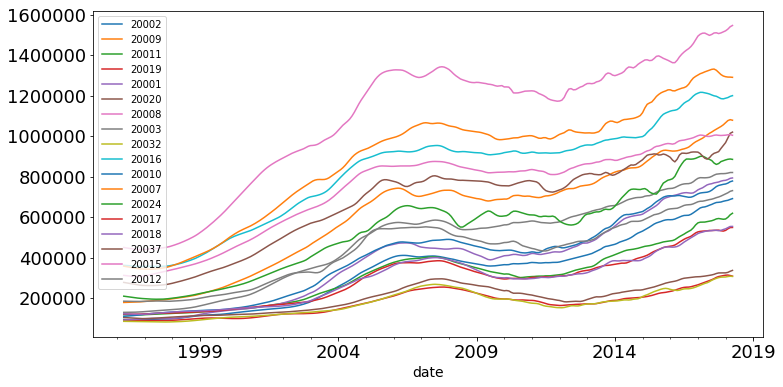

In [90]:
# check for NA
dc_df_T.plot()

# Some functions

In [519]:
from statsmodels.tsa.stattools import adfuller
def ADF_Test(timeseries):
    """
    ADF_Test 
    print out parameters from the Dickey-Fuller test
    """
    #     print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dfoutput['p-value'] 
#     print(pvalue)
#     print(dfoutput)
    return pvalue

In [520]:

def Compare_Transformations(data, tdata):
    """ 
    Compare the data vs a trsnsformation of the  data
    drop null values, run an ADF test and return the p-value
    """
    tdiff = data - tdata
    tdiff.dropna(inplace=True)
    pvalue = ADF_Test(tdiff)

#     data.plot()
#     tdata.plot()
    return pvalue

In [521]:
def Plot_Compare(data, tdata):
    """
    Plot the difference between data and tdata
    To see if difference is stationary
    """
    y_diff = data - tdata
    y_diff.dropna(inplace=True)
    pval = Compare_Transformations(data,tdata)
    
    fig = plt.figure(figsize=(12,6))
    y_diff.plot()
    title = ' p-value: {0:1.2}'.format(pval)
    plt.title(title,fontsize=18)
    plt.xlabel('Date', fontsize=16)
    plt.ylabel(r'Delta data', fontsize=16)
    plt.grid(True)

In [522]:
def Get_Best_Model(data, p_params, q_params):
    """
    Use a SARIMAX fit to get the best model for the data
    
    Return
    Return the model with the lowest AIC
    """
    lowest_AIC =1e14
    best_param =0
    best_seasonal_param = 0
    p = range(0,np.max(p_params))
    d = range(0,2)
    q = range(0,np.max(q_params))

    pdq = list(itertools.product(p,d,q))
    seasonal_pdq = [(x[0], x[1],x[2],12) for x in list(itertools.product(p, d, q))]
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                
                mod = sm.tsa.statespace.SARIMAX(data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
                results = mod.fit()

                if results.aic < lowest_AIC:
                    lowest_AIC = results.aic
                    best_model = mod
                    best_param = param
                    best_seasonal_param = param_seasonal

            except:
                continue
            
    return best_model, best_param, best_seasonal_param

In [523]:
from statsmodels.tsa.stattools import pacf
def Get_q_params(data):
    """
    Get the p Parameters from an PACF 
    """
    pcfarray, confintarray = pacf(data, alpha=.05)
    obs = len(data)
    q_params = []
    for i,v in enumerate(pcfarray):
        if (v <= (-1.96/np.sqrt(obs)) or v >= (1.96/np.sqrt(obs))) and i > 0:
            q_params.append(i)
    return q_params[:2]

In [524]:
from statsmodels.tsa.stattools import acf
def Get_p_params(data):
    """
    Get the p Parameters from an ACF 
    """
    acfarray, confintarray = acf(data, alpha=.05)
    obs = len(data)
    p_params = []
    for i,v in enumerate(acfarray):
        if (v <= (-1.96/np.sqrt(obs)) or v >= (1.96/np.sqrt(obs))) and i > 0:
            p_params.append(i)
    return p_params[:2]

In [525]:

def Trend_elimination(data):
    """
    Apply different transformation on the data, calculate the p-value 
    from a ADF test, and return the data set with the lowest p-value
    """
    data_transformed = []
    pvalues = []
    name = []
    
    # log data
#     print('Log data')
    name.append('Log_data')
    data_log = np.log(data)
    pvalue = Compare_Transformations(data, data_log)
    data_transformed.append(data_log)
    pvalues.append(pvalue)
    
    # sqrt
#     print('sqrt')
    name.append('sqrt_data')
    data_sqrt = np.sqrt(data)
    pvalue = Compare_Transformations(data, data_sqrt)
    data_transformed.append(data_sqrt)
    pvalues.append(pvalue)

#     print('diff 1')
    # diff
    name.append('diff_data')
    data_diff = data.diff()
    pvalue = Compare_Transformations(data, data_diff)
    data_transformed.append(data_diff)
    pvalues.append(pvalue)
    
#     print('rolling mean on data')
    # rolling mean
    name.append('rolling_mean_data')
    data_roll_mean = data.rolling(window=3).mean()
    pvalue = Compare_Transformations(data, data_roll_mean)
    data_transformed.append(data_roll_mean)
    pvalues.append(pvalue)
    
    # EWM
#     print('ewm on data')
    name.append('ewm_data')
    data_ewm = data.ewm(halflife= 2).mean()
    pvalue = Compare_Transformations(data, data_ewm)
    data_transformed.append(data_ewm)
    pvalues.append(pvalue)
    
    # on the log
    # rolling mean
#     print('rolling mean on log data')
    name.append('log_rolling_mean_data')
    data_log_roll_mean = data_log.rolling(window=3).mean()
    pvalue = Compare_Transformations(data, data_log_roll_mean)
    data_transformed.append(data_log_roll_mean)
    pvalues.append(pvalue)
    # EWM
    
#     print('EWM on log data')
    name.append('log_ewm_data')
    data_log_ewm = data_log.ewm(halflife= 2).mean()
    pvalue = Compare_Transformations(data, data_log_ewm)
    data_transformed.append(data_log_ewm)
    pvalues.append(pvalue)
    
#     print('EWM on rolling mean of log data')
    name.append('log_rollmean_ewm_data')
    data_log_roll_mean_ewm = data_log_roll_mean.ewm(halflife=2).mean()
    pvalue = Compare_Transformations(data, data_log_roll_mean_ewm)
    data_transformed.append(data_log_roll_mean_ewm)
    pvalues.append(pvalue)
    
    
    #compare all p-values and return the lowest one
    pvalue_min = np.min(pvalues)
#     print(pvalue_min)
    lowesti = pvalues.index(pvalue_min)
    return name[lowesti], pvalue_min, data_transformed[lowesti]

In [563]:
def Make_PredictionPlot(results, ytrain, ytest, zipcode):
    fig = plt.figure(figsize=(14,7))
    pred = results.get_prediction(start=pd.to_datetime('2017-07'),
                              end=pd.to_datetime('2019-04'),
                             dynamic=True)
    pred_ci = pred.conf_int() 


    ax = ytrain.plot(label='observed')
    ytest.plot(ax=ax, label='y_test',lw=4, c='b')
    pred.predicted_mean.plot(ax = ax, label='Prediction')
    ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1], color='k', alpha=0.2)

    pred_future = results.get_forecast(steps=16)
    pred_ci2 = pred_future.conf_int()

#     pred_future.predicted_mean.plot(ax=ax, label=' Future Forecast')
#     ax.fill_between(pred_ci2.index, 
#                pred_ci2.iloc[:,0],
#                pred_ci2.iloc[:,1], color='k',alpha = 0.25)

    plt.title('Zipcode {}'.format(zipcode), fontsize=18)
    plt.xlabel('Date',fontsize=18)
    plt.ylabel('Price', fontsize=18)
    plt.legend(fontsize=12)
    plt.grid(True)

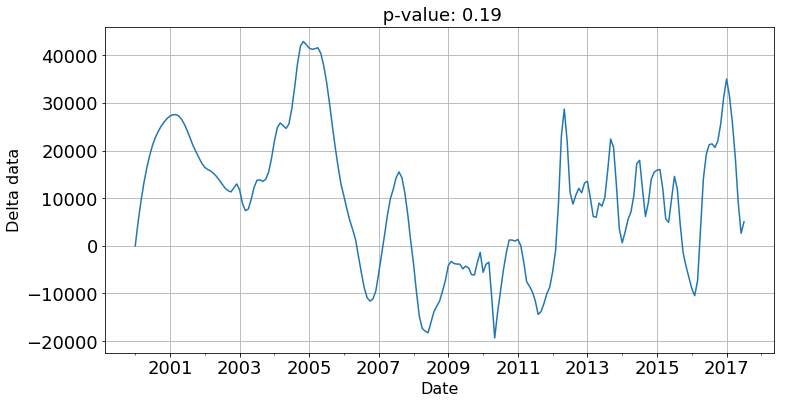

In [413]:
Plot_Compare(y_train, ybest_data)

In [ ]:
zipcode = zipcodes[6]
time_start = '2000'

time_cut = '2017-07'
y = dc_df_T[zipcode].resample('MS').mean()
y_train = y[time_start:time_cut]

y_test = y[time_cut:]
y_test = y_test[1:]

y_train.tail(), y_test.head()

# decomp = sm.tsa.seasonal_decompose(y, model='additive')

# fig = plt.figure()
# fig = decomp.plot()
# fig.set_size_inches(15, 12)

In [ ]:
name, pvalue, ybest_data = Trend_elimination(y_train)
# y_sqrt.plot()
print("The best data is the '{}' data set".format(name))

In [584]:
results = []
train_data = []
test_data =[]
time_start = '2012'
time_cut = '2017-07'

for zipcode in zipcodes:
    
    y = dc_df_T[zipcode].resample('MS').mean()
    y_train = y[time_start:time_cut]

    y_test = y[time_cut:]
    y_test = y_test[1:]
    
    # make it stationary
    name, pvalue, ybest_data = Trend_elimination(y_train)    
    print("{} The best data is the '{}' data set".format(zipcode, name))
    
    # Get the Parameters on the difference between y and ybest
    y_diff = y_train - ybest_data
    y_diff.dropna(inplace=True)
    p_params = Get_p_params(y_diff)
    q_params = Get_q_params(y_diff)
    
    # Fit the MODEL
    model, best_order, best_seasonal_order = Get_Best_Model(y_train,
                                                        p_params,
                                                        q_params)
    
    result = model.fit()
    results.append(result)
    train_data.append(y_train)
    test_data.append(y_test)

20002 The best data is the 'rolling_mean_data' data set
20009 The best data is the 'rolling_mean_data' data set
20011 The best data is the 'ewm_data' data set
20019 The best data is the 'rolling_mean_data' data set
20001 The best data is the 'rolling_mean_data' data set
20020 The best data is the 'rolling_mean_data' data set
20008 The best data is the 'ewm_data' data set
20003 The best data is the 'rolling_mean_data' data set
20032 The best data is the 'rolling_mean_data' data set
20016 The best data is the 'rolling_mean_data' data set
20010 The best data is the 'rolling_mean_data' data set
20007 The best data is the 'rolling_mean_data' data set
20024 The best data is the 'ewm_data' data set
20017 The best data is the 'rolling_mean_data' data set
20018 The best data is the 'rolling_mean_data' data set
20037 The best data is the 'rolling_mean_data' data set
20015 The best data is the 'rolling_mean_data' data set
20012 The best data is the 'rolling_mean_data' data set


In [551]:
len(test_)

4

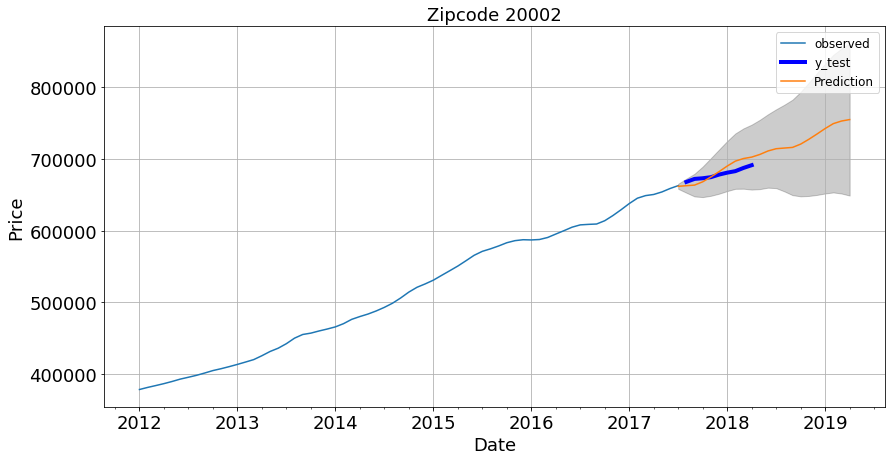

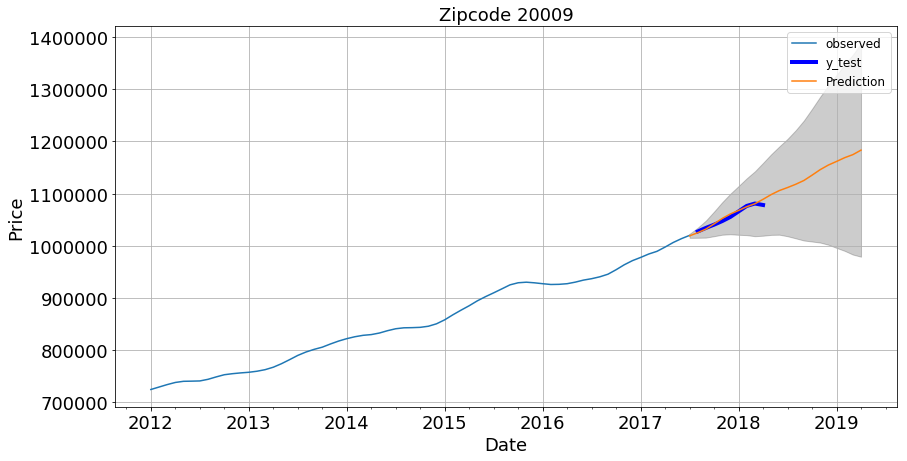

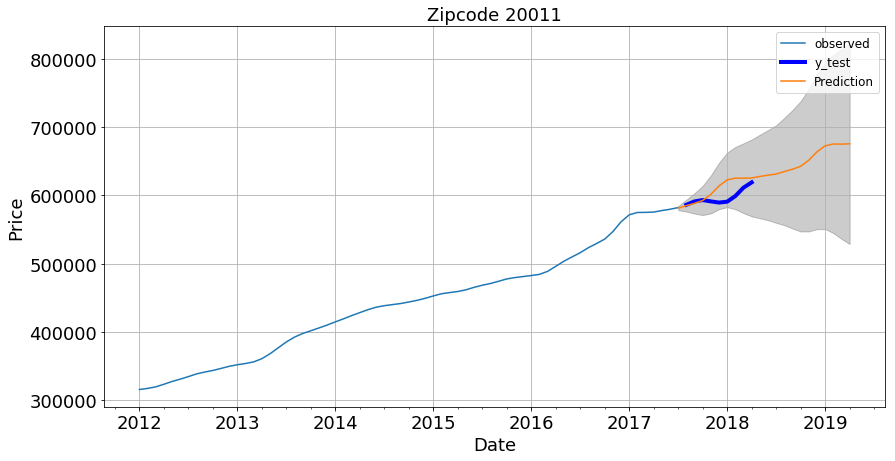

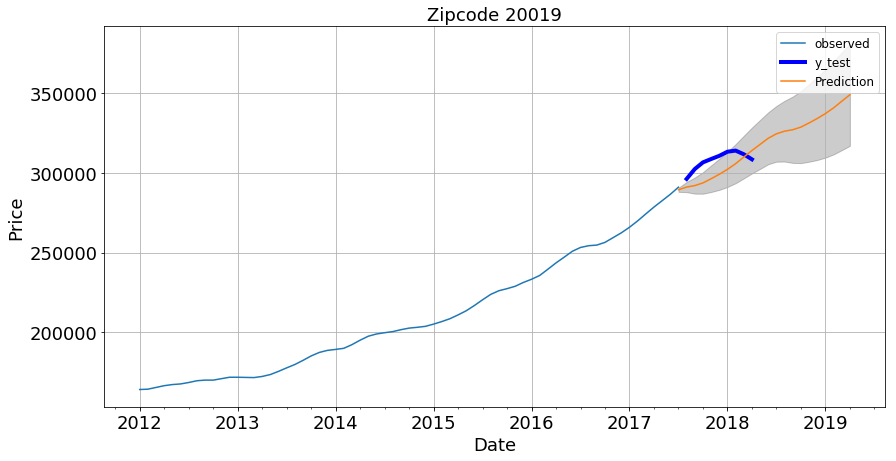

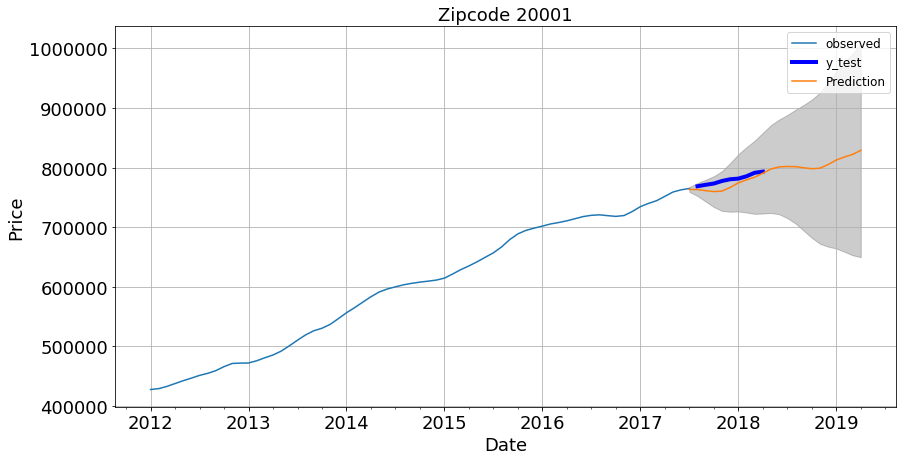

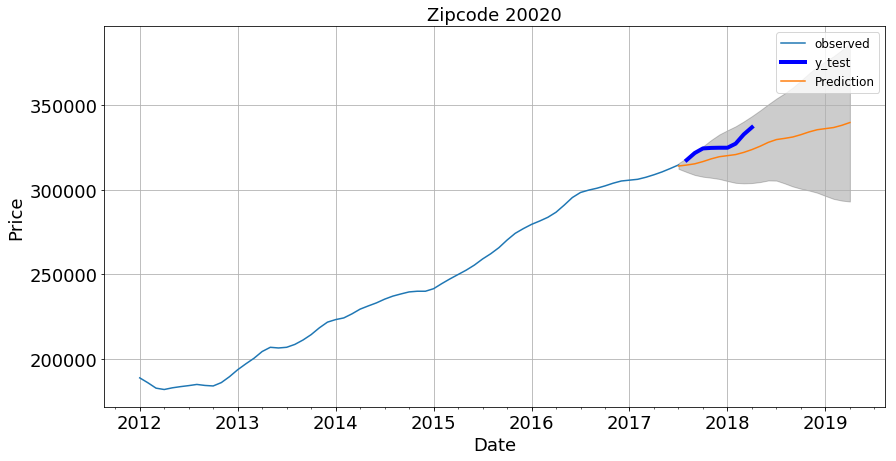

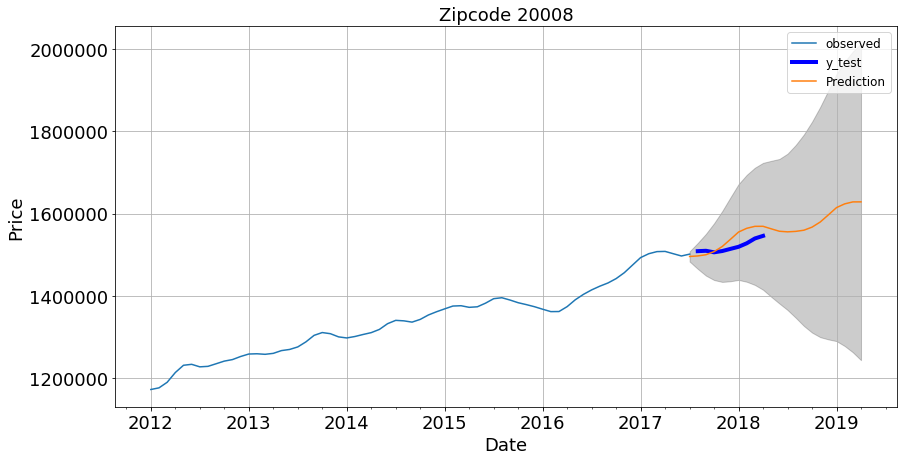

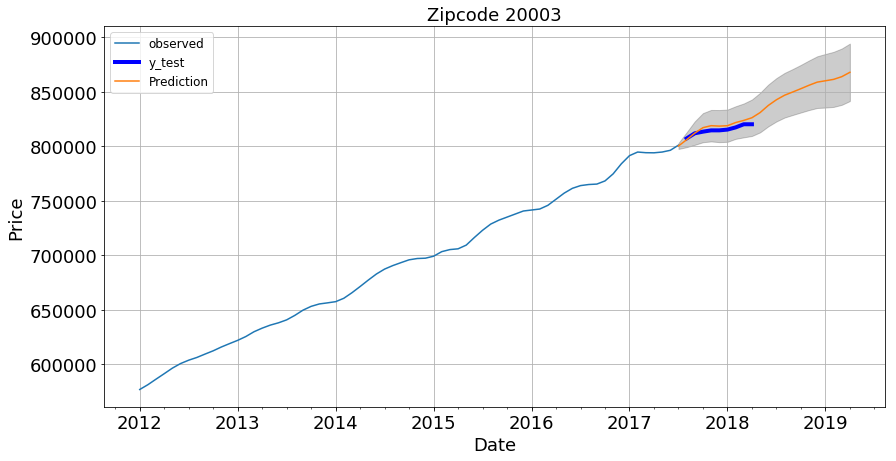

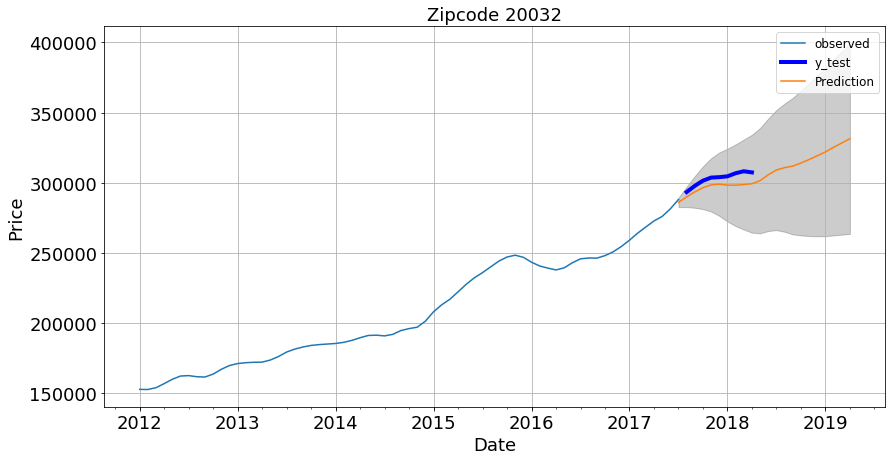

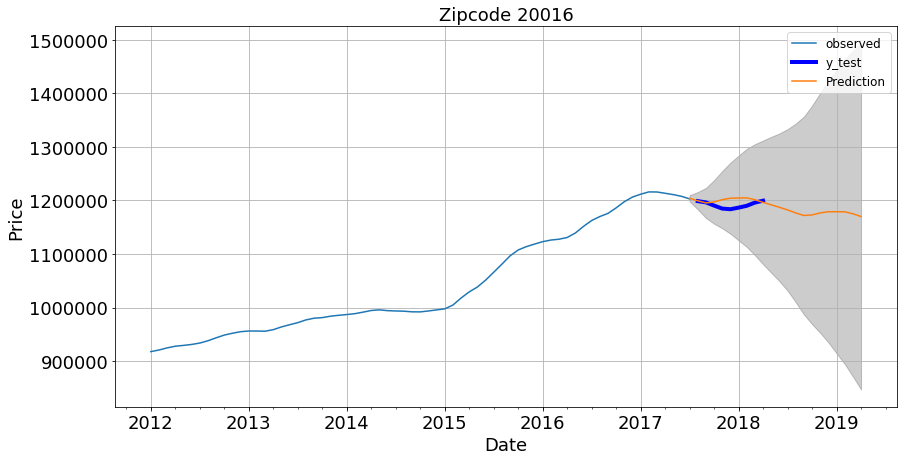

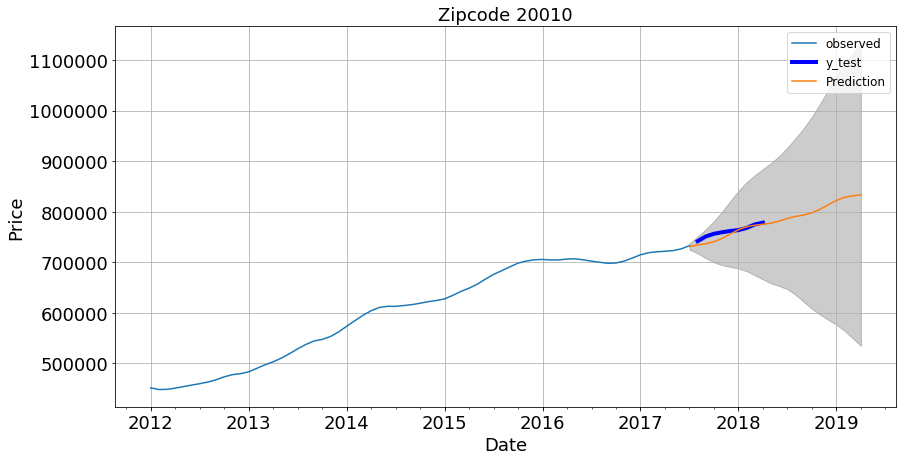

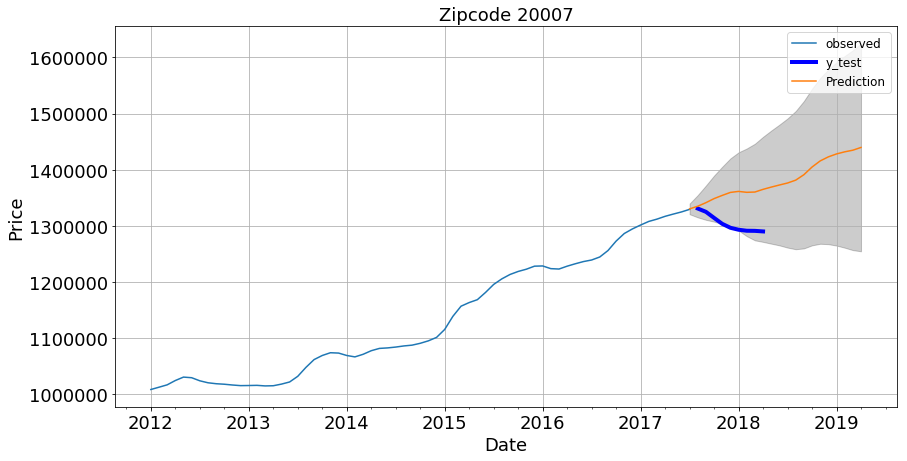

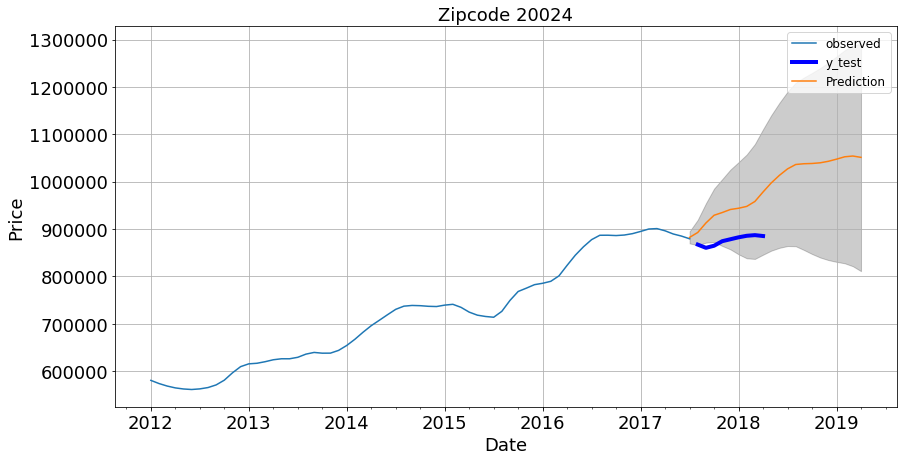

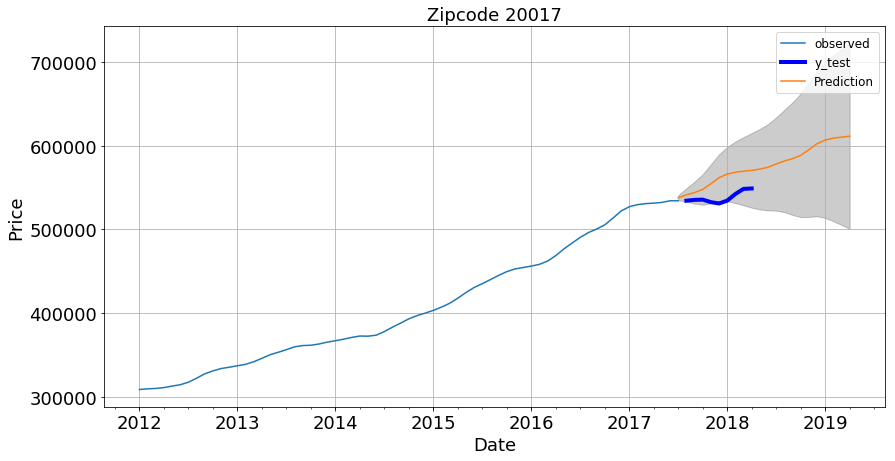

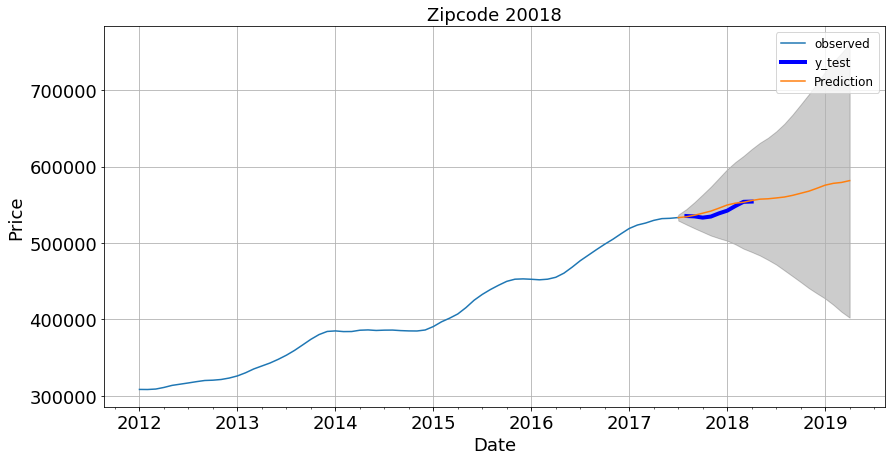

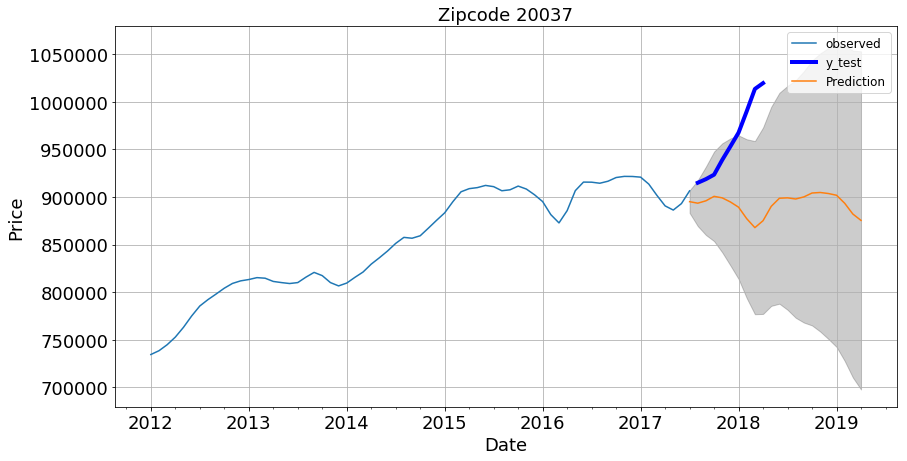

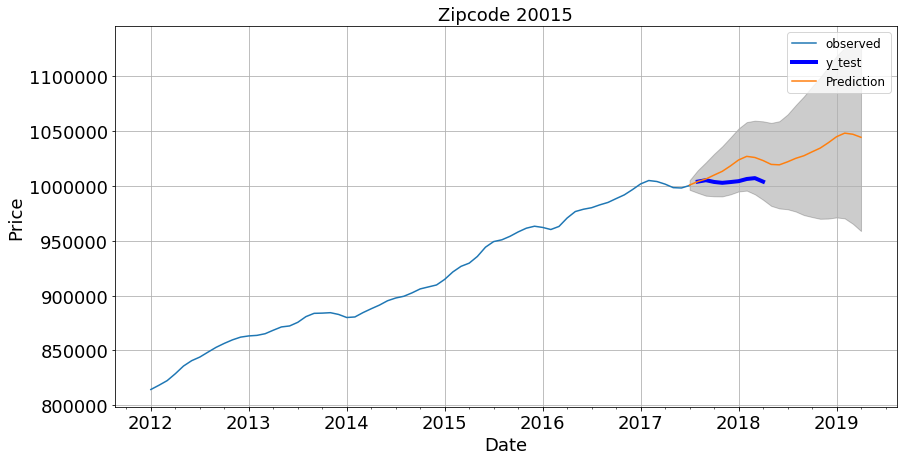

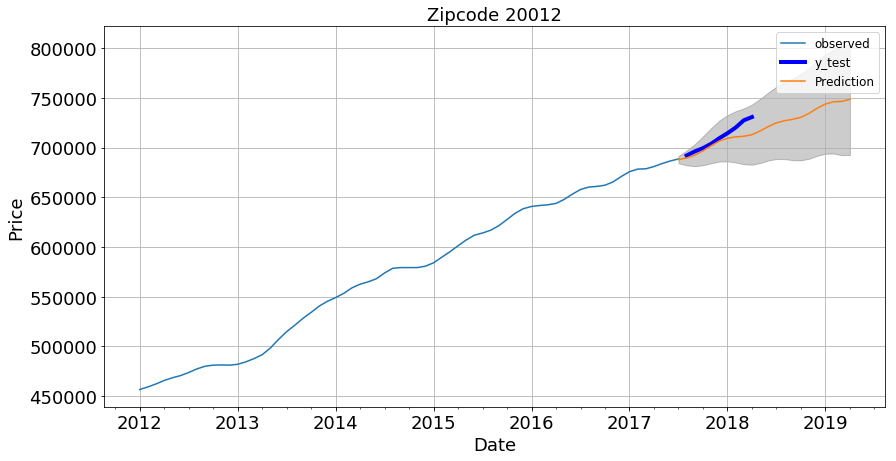

In [585]:
for i, val in enumerate(zipcodes):
    print
    Make_PredictionPlot(results[i], train_data[i], test_data[i], val)

In [581]:
import pickle
PIK = "zillow_fits.pkl"


with open(PIK, "wb") as f:
    for res in results:
        print(res)
        pickle.dump(res, f)

In [582]:
# fileObject = open(PIK,'r')  
# load the object from the file into var b
# fit_results = pickle.load(fileObject)
fit_results = []
with open(PIK, "rb") as f:
    for i in range(4):
        fit_results.append(pickle.load(f))


In [583]:
fit_results

# ACF and PACF 

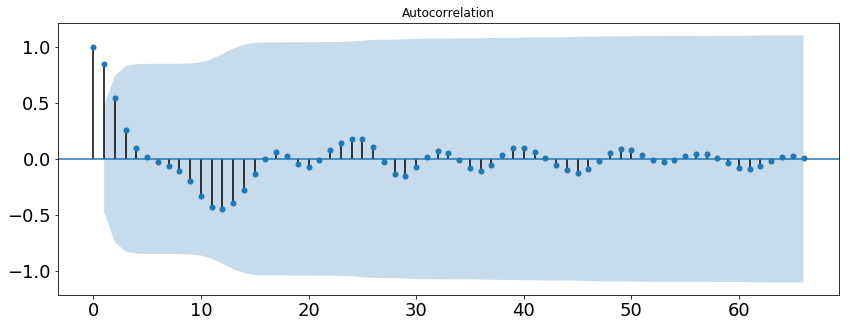

In [480]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
# auto_acf = acf(y_diff)

# plot(auto_acf)
plot_acf(y_diff,alpha=0.0001);
# acf, conf_int = sm.tsa.acf(y_diff, confint=0.95)
acfvals , acf_conf=  sm.tsa.acf(y_diff, alpha=0.0001)
# print(acf(y_diff, confint=95))
# pacf(y_diff,confint=95)

In [460]:
acfvals

array([ 1.        ,  0.85288851,  0.54363209,  0.2622149 ,  0.09628904,
        0.0129008 , -0.03093801, -0.05955869, -0.10459187, -0.20078257,
       -0.33123145, -0.43147491, -0.4513413 , -0.39242644, -0.27997782,
       -0.13710055, -0.00480366,  0.06177762,  0.0288313 , -0.0465757 ,
       -0.06869786, -0.00776155,  0.07937831,  0.14321861,  0.17801485,
        0.17514796,  0.10387914, -0.02644089, -0.13524318, -0.14882157,
       -0.07324768,  0.02120442,  0.07338172,  0.05710728, -0.01213045,
       -0.0851986 , -0.10547042, -0.05293397,  0.03516725,  0.09621615,
        0.09957321])

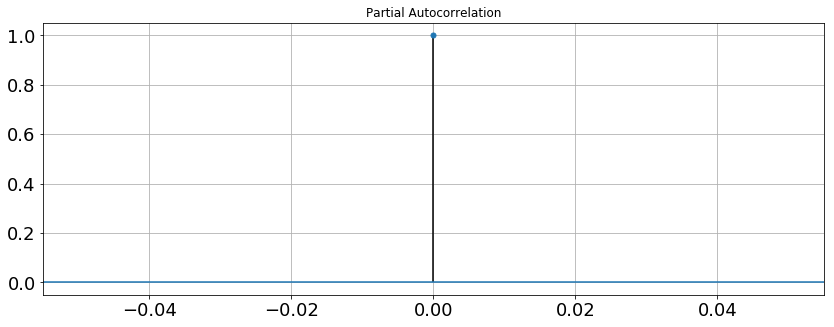

In [590]:
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5

# plot_pacf(ybest_data, lags = 12);
plt.grid(True)

In [587]:
q_params

[1, 2]

In [588]:
p_params

[1, 2]

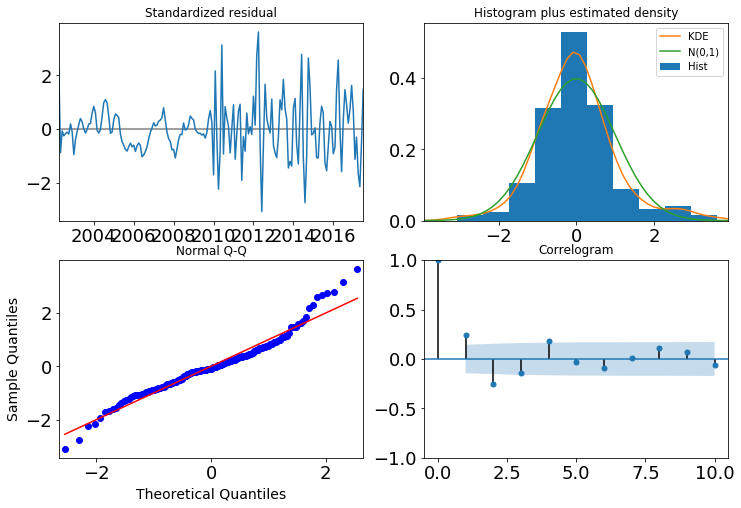

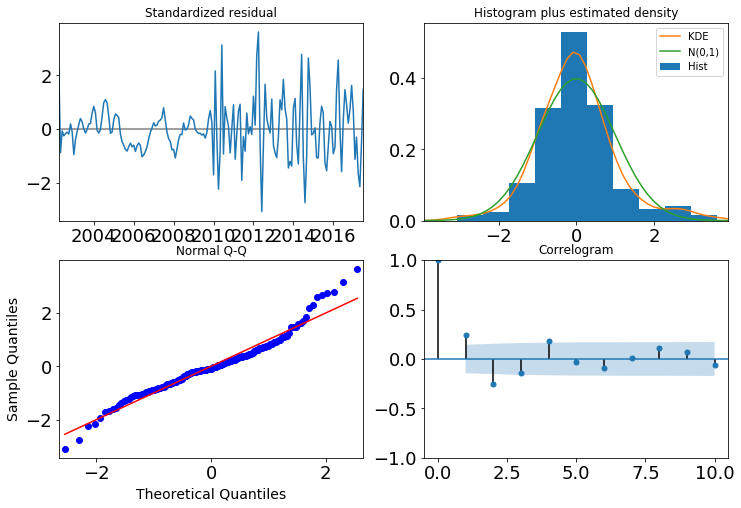

In [514]:
results.plot_diagnostics(figsize=(12,8))

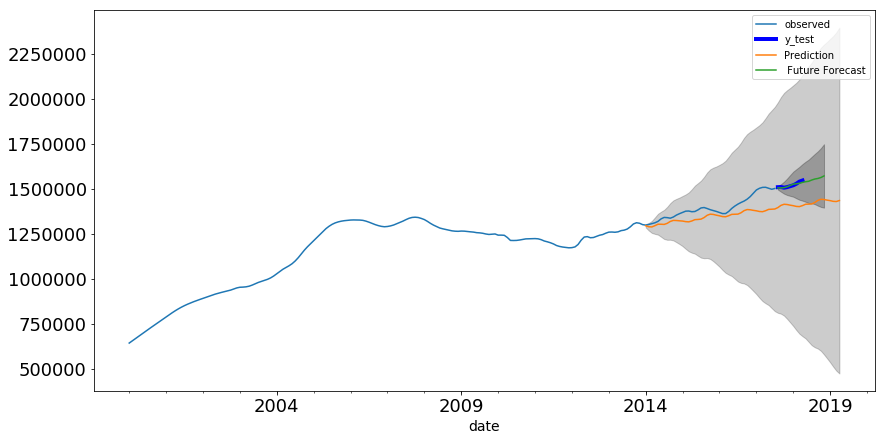

In [516]:
pred = results.get_prediction(start=pd.to_datetime('2014'),
                              end=pd.to_datetime('2019-04'),
                             dynamic=True)
pred_ci = pred.conf_int() 


ax = y_train.plot(label='observed')
y_test.plot(ax=ax, label='y_test',lw=4, c='b')
pred.predicted_mean.plot(ax = ax, label='Prediction',figsize=(14,7))
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1], color='k', alpha=0.2)

pred_future = results.get_forecast(steps=16)
pred_ci2 = pred_future.conf_int()

pred_future.predicted_mean.plot(ax=ax, label=' Future Forecast')
ax.fill_between(pred_ci2.index, 
               pred_ci2.iloc[:,0],
               pred_ci2.iloc[:,1], color='k',alpha = 0.25)


plt.legend()

AttributeError: 'PredictionResults' object has no attribute 'prediction_mean'